In [ ]:
# US stock prediction

ライブラリ

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# 必要情報の入力
start = '2021-01-04'
end = '2024-02-01'
tickers = 'TSLA'  # 予測対象の株価シンボル
seq_length = 5 #周期性がどの程度あるのか？ここをよく見ながら設定すること！！
num_test = 2 # 予測日数
hidden_size = 200 # 隠れ層数の設定
num_epochs = 50 # エポック数の設定


# 株価データの取得
y = yf.download(tickers, start=start, end=end)["Close"]

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y.values.reshape(-1, 1))

# ランダムシードの固定化
seed_value = 42
np.random.seed(seed_value)

plt.style.use("ggplot")
%matplotlib inline

print(f"start:{start} end:{end} ticker:{tickers}")



[*********************100%%**********************]  1 of 1 completed

start:2021-01-04 end:2024-02-01 ticker:TSLA


In [27]:
#seq_length=10
#num_test=10
print(f"最後尾のデータは{scaled_data[-1]}")
maxnum=len(scaled_data)
ii=0
jj=0
yy=[]
for ii in range(seq_length):
  #yy=[]
  for jj in range(num_test):
    yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
    yy.append(yy_value)
    #print(f"count:{ii+jj-seq_length-num_test+2} {yy}")
    jj+=1
#print(yy)

# yyをtorch.Tensorに変換
yy_tensor = torch.tensor(yy)

# yy_tensorを表示
#print(yy_tensor)

# もしくは
yy_tensor_reshaped = yy_tensor.view(seq_length,num_test)
print(yy_tensor_reshaped)


最後尾のデータは[0.26233145]
tensor([[0.3304, 0.2469],
        [0.2469, 0.2489],
        [0.2489, 0.2744],
        [0.2744, 0.2766],
        [0.2766, 0.2623]])


<ipython-input-27-407733de25c1>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])


教師データ

In [ ]:
y= scaled_data
y=y.squeeze()
allsize = y.shape[0]
print(allsize)
x = np.linspace(0,allsize-1,allsize)
print(y.shape)
print(y.shape)

774
(774,)
(774,)


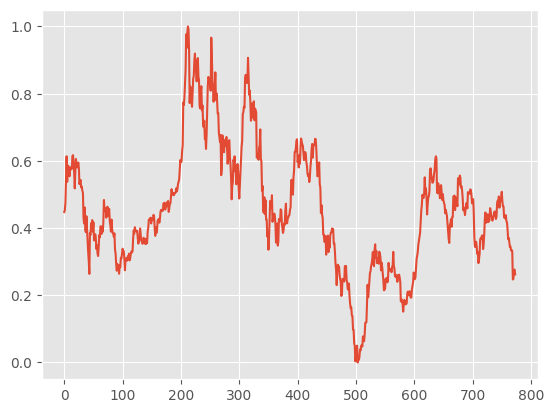

In [ ]:
plt.plot(x,y)

窓スライド処理

In [ ]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = [] # 4つ刻みのデータを格納する用のリスト
  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  #return seq_arr, target_arr
  return seq_arr.squeeze(), target_arr.squeeze()

In [ ]:
y_seq, y_target = make_sequence_data(y , seq_length)

In [ ]:
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [ ]:
y_seq_train.shape

(767, 5)

pytorch用の処理

In [ ]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [ ]:
y_target_t.shape
#y_seq_t.shape

torch.Size([767])

LSTMの定義
 #x_last=x[-1]は予測したラストを抽出

In [ ]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [ ]:
model = LSTM(hidden_size)

Loss関数と最適化アルゴの定義

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

LSTMに入力するための処理

In [ ]:
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [ ]:
y_seq_t = y_seq_t.permute(1,0)

In [ ]:
# 40×450の2次元テンサーなので、1次元にする必要がる
 # unsqueezeはsqueezeの反対なのでsqueezeは40x450x1を絞って40x450にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [ ]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [ ]:
y_seq_t.shape

torch.Size([5, 767, 1])

学習トレーニング
ミニバッチのランニングLossを初期化することが通常だが
今回はバッチ学習のためいきなりOptimizerの初期化を実施します

In [ ]:

losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 0.32263699173927307
epoch: 10, loss: 0.05756764113903046
epoch: 20, loss: 0.025073522701859474
epoch: 30, loss: 0.02519330009818077
epoch: 40, loss: 0.018598133698105812


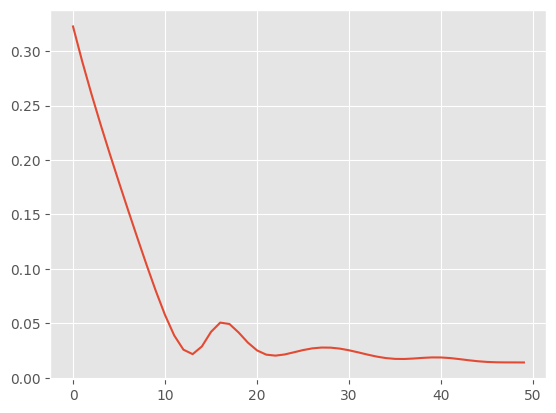

In [ ]:
plt.plot(losses)

In [ ]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [ ]:
y_seq_test_t.size()

torch.Size([5, 2, 1])

In [ ]:
#print(y_seq_test_t)

In [ ]:
y_pred = model(y_seq_test_t)

(754.0, 776.0)

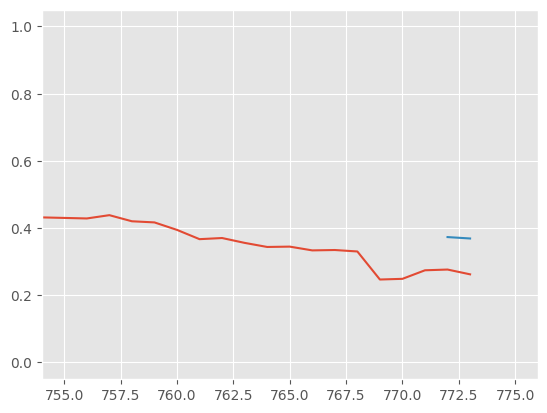

In [ ]:
plt.plot(x,y)
plt.plot(np.arange(allsize-num_test,allsize),y_pred.detach())
plt.xlim([allsize-num_test*10,allsize+num_test])

In [ ]:
print(y[-5:])

[0.24689438 0.24894823 0.27438962 0.276576   0.26233145]


予測

In [ ]:
input_sequence.size()

NameError: name 'input_sequence' is not defined

In [ ]:
# 予測 1日予測→入力→予測→入力→予測を繰り返して、任意の期間を予測する

predictions = []
with torch.no_grad():
    input_sequence = y_seq_test_t[:, -seq_length:, :]
    print(input_sequence)
    for i in range(num_test):
        output = model(input_sequence)
        prediction = output[-1].item()  # 最後の時点での予測値を取得
        predictions.append(prediction)
        # 前の予測結果を次の入力として使用
        new_input = torch.FloatTensor([[prediction]])
        print(new_input.size())
        print(new_input)
        #input_sequence = torch.cat((input_sequence[:, 1:, :], new_input), dim=1)

# 予測結果の逆正規化
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 予測結果の出力
#print("Predicted closing prices for 2024-03-04 to 2024-03-05:")
print(predictions)


In [ ]:
### 毎日1日毎の予測を実施

In [ ]:
import numpy as np

# 予測データを格納するリスト
pred_data = []

# 予測対象の日付
target_date = '2024-02-01'

# 予測対象の日付のインデックスを取得
target_index = np.where(y.index == target_date)[0][0]

# 予測データの生成と格納
for i in range(num_test):
    pred_data_temp = []
    for j in range(seq_length):
        pred_data_temp.append([scaled_data[target_index - seq_length + j + i, 0], scaled_data[target_index - seq_length + j + i + 1, 0]])
    pred_data.append(pred_data_temp)

# モデルを使って予測を行い、結果を格納
for i in range(num_test):
    pred_temp = model(pred_data[i])
    pred_data[i].append([scaled_data[target_index + i, 0], pred_temp])

# 結果の表示
for i in range(num_test):
    print(f"2024-02-0{i+2}の予測結果: {scaler.inverse_transform(np.array(pred_data[i])[:, -1].reshape(-1, 1)).flatten()[seq_length]}")


AttributeError: 'numpy.ndarray' object has no attribute 'index'